# SquareRoot Notebook
***Made by Phuong-Linh Nguyen (deLini1612)***

This notebook is used to test the mathematical aspect of the approx algorithm as well as validate the result

---

# Error and correction term

## Proposed terms by the paper

In [15]:
import numpy as np
from math import sqrt
import scipy.integrate as spi
import pandas as pd

# Define the Error function
def Em1(x, y):
    return (1+x+y)/((1+x)*(1+y)) - 1
def Em2(x, y):
    return (2*(x+y))/((1+x)*(1+y)) - 1

def Ed1(x, y):
    return ((1+x-y)*(1+y))/(1+x) - 1
def Ed2(x, y):
    return ((2+x-y)*(1+y))/(2*(1+x)) - 1

def Es(x):
    return (2**(x/2))/(sqrt(1+x)) - 1

def partial_correction_mul(E, x_lower_func, x_upper_func, y_lower, y_upper):
  """Computes the integral of - np.log2(1/(1-E)) over given limits for mul"""
  def integrand(x, y):
      return - np.log2(1/(1-E(x, y))) #Note: minus to obtain positive correction term

  try:
      result, _ = spi.dblquad(integrand, y_lower, y_upper, x_lower_func, x_upper_func)
      return result
  except Exception:
      return "Error"

def partial_correction_div(E, x_lower_func, x_upper_func, y_lower, y_upper):
  """Computes the integral of - np.log2(1/(1-E)) over given limits for div"""
  def integrand(x, y):
      return np.log2(1/(1-E(x, y)))

  try:
      result, _ = spi.dblquad(integrand, y_lower, y_upper, x_lower_func, x_upper_func)
      return result
  except Exception:
      return "Error"

def compute_correction_mul(x_lower, x_upper, y_lower, y_upper):
  """Computes the correction term of multiplication"""
  x_lower_func = lambda y: x_lower
  x_upper_func = lambda y: x_upper
  x_intermediate_func = lambda y: 1 - y
  if (x_lower + y_lower) >= 1:
    return partial_correction_mul(Em2, x_lower_func, x_upper_func, y_lower, y_upper)/((x_upper-x_lower)*(y_upper-y_lower))
  elif (x_upper + y_upper) < 1:
    return partial_correction_mul(Em1, x_lower_func, x_upper_func, y_lower, y_upper)/((x_upper-x_lower)*(y_upper-y_lower))
  else:
    partial1 = partial_correction_mul(Em1, x_lower_func, x_intermediate_func, y_lower, y_upper)
    partial2 = partial_correction_mul(Em2, x_intermediate_func, x_upper_func, y_lower, y_upper)
    return (partial1 + partial2)/((x_upper-x_lower)*(y_upper-y_lower))

def compute_correction_div(x_lower, x_upper, y_lower, y_upper):
  """Computes the correction term of division"""
  x_lower_func = lambda y: x_lower
  x_upper_func = lambda y: x_upper
  x_intermediate_func = lambda y: y
  if (x_lower >= y_upper):
    return partial_correction_div(Ed1, x_lower_func, x_upper_func, y_lower, y_upper)/((x_upper-x_lower)*(y_upper-y_lower))
  elif (x_upper < y_lower):
    return partial_correction_div(Ed2, x_lower_func, x_upper_func, y_lower, y_upper)/((x_upper-x_lower)*(y_upper-y_lower))
  else:
    partial1 = partial_correction_div(Ed2, x_lower_func, x_intermediate_func, y_lower, y_upper)
    partial2 = partial_correction_div(Ed1, x_intermediate_func, x_upper_func, y_lower, y_upper)
    return (partial1 + partial2)/((x_upper-x_lower)*(y_upper-y_lower))

def compute_correction_root(x_lower, x_upper):
  """Computes the correction term of square root"""
  def root_term(x):
    return - np.log2(1/(1-Es(x))) #Note: minus to obtain positive correction term
  result, _ = spi.quad(root_term, x_lower, x_upper)
  return result/(x_upper-x_lower)

def no_correction(*args):
  return 0

## New proposed correction terms (For Em and Es)

We change 1-E to 1+E inside integrand instead of get minus of the term for Em, new Es

In [16]:
def partial_correction_mul_new(E, x_lower_func, x_upper_func, y_lower, y_upper):
  def integrand_mul(x, y):
      return np.log2(1/(1+E(x, y)))

  try:
      result, _ = spi.dblquad(integrand_mul, y_lower, y_upper, x_lower_func, x_upper_func)
      return result
  except Exception:
      return "Error"

def compute_correction_mul_new(x_lower, x_upper, y_lower, y_upper):
  """Computes the correction term of multiplication"""
  x_lower_func = lambda y: x_lower
  x_upper_func = lambda y: x_upper
  x_intermediate_func = lambda y: 1 - y
  if (x_lower + y_lower) >= 1:
    return partial_correction_mul_new(Em2, x_lower_func, x_upper_func, y_lower, y_upper)/((x_upper-x_lower)*(y_upper-y_lower))
  elif (x_upper + y_upper) < 1:
    return partial_correction_mul_new(Em1, x_lower_func, x_upper_func, y_lower, y_upper)/((x_upper-x_lower)*(y_upper-y_lower))
  else:
    partial1 = partial_correction_mul_new(Em1, x_lower_func, x_intermediate_func, y_lower, y_upper)
    partial2 = partial_correction_mul_new(Em2, x_intermediate_func, x_upper_func, y_lower, y_upper)
    return (partial1 + partial2)/((x_upper-x_lower)*(y_upper-y_lower))

In [17]:
def Es1(x): #Es always positive
  '''Error when k+x < 2, aka k = 1'''
  return (x/2.0+1.5)/(sqrt(1+x)) - 1
def Es2(x):
  '''Error when k>= 2 and k even'''
  return (x/2.0 + 1)/(sqrt(1+x)) - 1
def Es3(x):
  '''Error when k>= 2 and k odd'''
  return (x/2.0 + 1.5)/(sqrt(2*(1+x))) - 1

def compute_correction_root_new(E, x_lower, x_upper):
  """Computes the integral of np.log2(1/(1+E)) over given limits"""
  def integrand(x):
      return np.log2(1/(1-E(x)))
  try:
      result, _ = spi.quad(integrand, x_lower, x_upper)/(x_upper-x_lower)
      return result
  except Exception:
      return "Error"

# Mitchell BNS - LNS approx func

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

def mitchell_b2l(x: int, N: int):
    """Convert x (Nbit) to log representation (N + floor(log2(N-1)) bit) using Mitchell's approximation"""
    if x == 0:
        return -np.inf  # Log of zero is undefined, handle separately
    int_part = int(np.floor(np.log2(x)))
    shift_value = N-int_part-1
    fractional_part = x - (1 << int_part)
    scaled_fractional = (fractional_part) << shift_value
    scaled_int = int_part << (N-1)
    return [scaled_int + scaled_fractional, scaled_fractional]

def mitchell_l2b(scaled_log:int, N:int):
    """ Convert Mitchell scaled log representation (N + floor(log2(N-1)) + 1 bit) back to normal representation (2N bit)"""
    index_mostleft_one = scaled_log >> (N-1)
    if (index_mostleft_one < 0):
      index_mostleft_one = 0
    partial1 = 1 << (index_mostleft_one + N - 1)
    remaining_part = scaled_log%(1<<(N-1))
    partial2 = remaining_part << index_mostleft_one
    binformat = partial1 + partial2
    return binformat/(2**(N-1))

In [19]:
# Test
x = 13
y, _ = mitchell_b2l(x, 8)
print("In = {:08b}, Out = {:010b}, fraction = {:07b}".format(x,y, _))


z = mitchell_l2b(y, 8)
print("In = {:011b}, Out = {:f}".format(y,z))

In = 00001101, Out = 0111010000, fraction = 1010000
In = 00111010000, Out = 13.000000


# Full Validation

## Util function

In [20]:
def generate_ranges(N):
    '''Generate x anf y intervals'''
    points = np.linspace(0, 1, 2**N + 1)
    ranges = [(points[i], points[i + 1]) for i in range(len(points) - 1)]
    return ranges

In [21]:
def generate_muldiv_pd(N, correction):
  x_ranges = generate_ranges(N)
  y_ranges = generate_ranges(N)

  table = []

  for x_lower, x_upper in x_ranges:
      row = []
      for y_lower, y_upper in y_ranges:
          result = correction(x_lower, x_upper, y_lower, y_upper)
          row.append(result)
      table.append(row)

  # Create DataFrame
  datarame_pd = pd.DataFrame(table,
                    columns=[f"{yl[0]} → {yl[1]}" for yl in y_ranges],
                    index=[f"{xl[0]} → {xl[1]}" for xl in x_ranges])
  return datarame_pd

def generate_root_pd(N, correction):
    x_ranges = generate_ranges(N)
    table_root = []
    row_root = []

    for x_lower, x_upper in x_ranges:
        result_root = correction(x_lower, x_upper)
        row_root.append(result_root)
    table_root.append(row_root)

    # Create DataFrame
    datarame_pd = pd.DataFrame(table_root,
                    columns=[f"{xl[0]} → {xl[1]}" for xl in x_ranges])
    return datarame_pd

In [22]:
# new table for root
def generate_root_pd_new(N):
    x_ranges = generate_ranges(N)

    table_root = []
    row_root1 = []
    row_root2 = []
    row_root3 = []

    for x_lower, x_upper in x_ranges:
        row_root1.append(0)
        result_root = compute_correction_root_new(Es2, x_lower, x_upper)
        row_root2.append(result_root)
        result_root = compute_correction_root_new(Es3, x_lower, x_upper)
        row_root3.append(result_root)
    row_root1[0] = 0
    row_root1[2] = 1.5 - sqrt(2)
    row_root1[3] = 1.75 - sqrt(3)

    table_root.append(row_root1)
    table_root.append(row_root2)
    table_root.append(row_root3)

    # Create DataFrame
    root_tab_new = pd.DataFrame(table_root,
                    columns=[f"{xl[0]} → {xl[1]}" for xl in x_ranges],
                    index=["k <= 1 ", "k > 1 even", "k > 1 odd"])
    return root_tab_new

In [23]:
# Function for cal error
def get_error_mul(in1, in2, WIDTH, N, tab):
  log1, i = mitchell_b2l(in1, WIDTH)
  log2, j = mitchell_b2l(in2, WIDTH)
  i = i >> (WIDTH - 1 - N)
  j = j >> (WIDTH - 1 - N)

  correction_mul_float = tab.iloc[i, j]
  correction_mul = round(correction_mul_float * (2**(WIDTH-1)))

  log_mul = log1 + log2 + correction_mul
  mul = mitchell_l2b(log_mul, WIDTH)
  golden_mul = in1 * in2
  error_mul = (mul - golden_mul) / golden_mul

  return error_mul

def get_error_div(in1, in2, WIDTH, N, tab):
  log1, i = mitchell_b2l(in1, WIDTH)
  log2, j = mitchell_b2l(in2, WIDTH)
  i = i >> (WIDTH - 1 - N)
  j = j >> (WIDTH - 1 - N)

  correction_div_float = tab.iloc[i, j]
  correction_div = round(correction_div_float * (2**(WIDTH-1)))

  log_div = log1 - log2 - correction_div
  if(log_div) < 0:
    div = 0
  else:
    div = mitchell_l2b(log_div, WIDTH)
  golden_div = in1/in2
  error_div = (div - golden_div) / golden_div

  return error_div

def get_error_root(in1, WIDTH, N, tab):
  log1, i = mitchell_b2l(in1, WIDTH)
  i = i >> (WIDTH - 1 - N)

  correction_root_float = tab.iloc[0, i]
  correction_root = round(correction_root_float * (2**(WIDTH-1)))

  log_root = (log1 >> 1) + correction_root
  root = mitchell_l2b(log_root, WIDTH)
  golden_root = sqrt(in1)
  error_root = (root - golden_root) / golden_root

  return error_root

def get_error_root_new(in1, WIDTH, N, tab):
  log1, i = mitchell_b2l(in1, WIDTH)
  i = i >> (WIDTH - 1 - N)
  if (log1 >> (WIDTH - 1)) < 2:
    row = log1 >> (WIDTH - 2)
    correction_root_float = tab.iloc[0, row]
  else:
    correction_root_float = tab.iloc[(log1 >> (WIDTH - 1))%2 + 1, i]
  correction_root = round(correction_root_float * (2**(WIDTH-1)))
  log_root = (log1 >> 1) - correction_root
  root = mitchell_l2b(log_root, WIDTH)
  golden_root = sqrt(in1)
  relative_error = (root - golden_root) / golden_root
  abs_error = root - golden_root
  return abs_error, relative_error

def get_error_root_int_new(in1, WIDTH, N, tab):
  log1, i = mitchell_b2l(in1, WIDTH)
  i = i >> (WIDTH - 1 - N)
  if (log1 >> (WIDTH - 1)) < 2:
    row = log1 >> (WIDTH - 2)
    correction_root_float = tab.iloc[0, row]
  else:
    correction_root_float = tab.iloc[(log1 >> (WIDTH - 1))%2 + 1, i]
  correction_root = round(correction_root_float * (2**(WIDTH-1)))
  log_root = (log1 >> 1) - correction_root
  root = round(mitchell_l2b(log_root, WIDTH))
  golden_root = round(sqrt(in1))
  relative_error = (root - golden_root) / golden_root
  abs_error = root - golden_root
  return abs_error, relative_error

## Test with different NUM_SEGMENT, WIDTH

In [10]:
NUM_SEGMENT = 3
WIDTH = 8

### Generate table

In [11]:
no_correction_tab = generate_muldiv_pd(NUM_SEGMENT, no_correction)
no_correction_root_tab = generate_root_pd(NUM_SEGMENT, no_correction)

mul_correction_paper = generate_muldiv_pd(NUM_SEGMENT, compute_correction_mul)
mul_correction_proposed = generate_muldiv_pd(NUM_SEGMENT, compute_correction_mul_new)

div_correction_paper = generate_muldiv_pd(NUM_SEGMENT, compute_correction_div)

root_correction_paper = generate_root_pd(NUM_SEGMENT, compute_correction_root)
root_correction_proposed = generate_root_pd_new(NUM_SEGMENT)

### Get errors

In [12]:
inputs = list(product(range(1, 1 << WIDTH), repeat=2))  # list of (in1, in2)

In [13]:
error_mul_mitchell = [get_error_mul(in1, in2, WIDTH, NUM_SEGMENT, no_correction_tab) for in1, in2 in inputs]
error_mul_paper = [get_error_mul(in1, in2, WIDTH, NUM_SEGMENT, mul_correction_paper) for in1, in2 in inputs]
error_mul_proposed = [get_error_mul(in1, in2, WIDTH, NUM_SEGMENT, mul_correction_proposed) for in1, in2 in inputs]

error_div_mitchell = [get_error_div(in1, in2, WIDTH, NUM_SEGMENT, no_correction_tab) for in1, in2 in inputs]
error_div_paper = [get_error_div(in1, in2, WIDTH, NUM_SEGMENT, div_correction_paper) for in1, in2 in inputs]

error_root_mitchell = [get_error_root(in1, WIDTH, NUM_SEGMENT, no_correction_root_tab) for in1 in range(1, 2**WIDTH)]
error_root_paper = [get_error_root(in1, WIDTH, NUM_SEGMENT, root_correction_paper) for in1 in range(1, 2**WIDTH)]
error_root_proposed = [get_error_root_new(in1, WIDTH, NUM_SEGMENT, root_correction_proposed)[1] for in1 in range(1, 2**WIDTH)]

### Plot result

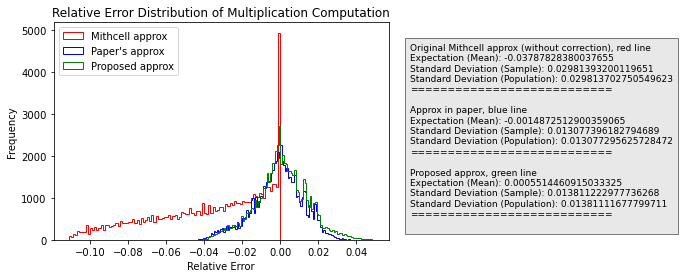

In [15]:
# Plot error distribution for mul
plt.hist(error_mul_mitchell, bins=100, edgecolor='red', histtype='step', label='Mithcell approx')
plt.hist(error_mul_paper, bins=100, edgecolor='blue', histtype='step',label="Paper's approx")
plt.hist(error_mul_proposed, bins=100, edgecolor='green', histtype='step', label='Proposed approx')

plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title('Relative Error Distribution of Multiplication Computation')

stats_lines = []

stats_lines.append("Original Mithcell approx (without correction), red line")
mean_value = np.mean(error_mul_mitchell)
std_dev_sample = np.std(error_mul_mitchell, ddof=1)
std_dev_population = np.std(error_mul_mitchell, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_lines.append("Approx in paper, blue line")
mean_value = np.mean(error_mul_paper)
std_dev_sample = np.std(error_mul_paper, ddof=1)
std_dev_population = np.std(error_mul_paper, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_lines.append("Proposed approx, green line")
mean_value = np.mean(error_mul_proposed)
std_dev_sample = np.std(error_mul_proposed, ddof=1)
std_dev_population = np.std(error_mul_proposed, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")

stats_lines.append("===========================\n")
plt.legend(loc="upper left")
stats_text = "\n".join(stats_lines)
plt.figtext(0.95, 0.17, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})
plt.savefig("ErrorTermCompare/Compare_mul_error.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

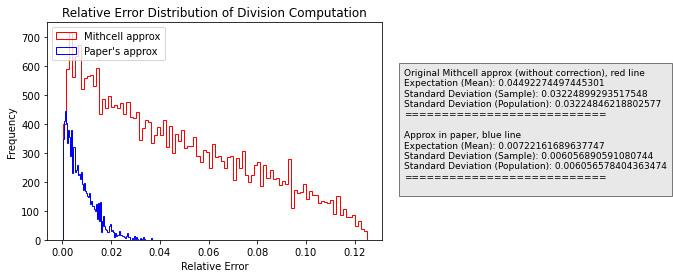

In [16]:
# Plot error distribution for div
# Remove all point in1 < in2
error_div_mitchell = [x for x in error_div_mitchell if x > 0]
error_div_paper = [x for x in error_div_paper if x > 0]

plt.hist(error_div_mitchell, bins=100, edgecolor='red', histtype='step', label='Mithcell approx')
plt.hist(error_div_paper, bins=100, edgecolor='blue', histtype='step',label="Paper's approx")

plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title('Relative Error Distribution of Division Computation')

stats_lines = []

stats_lines.append("Original Mithcell approx (without correction), red line")
mean_value = np.mean(error_div_mitchell)
std_dev_sample = np.std(error_div_mitchell, ddof=1)
std_dev_population = np.std(error_div_mitchell, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_lines.append("Approx in paper, blue line")
mean_value = np.mean(error_div_paper)
std_dev_sample = np.std(error_div_paper, ddof=1)
std_dev_population = np.std(error_div_paper, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

plt.legend(loc="upper left")
stats_text = "\n".join(stats_lines)
plt.figtext(0.95, 0.3, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})
plt.savefig("ErrorTermCompare/Compare_div_error.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

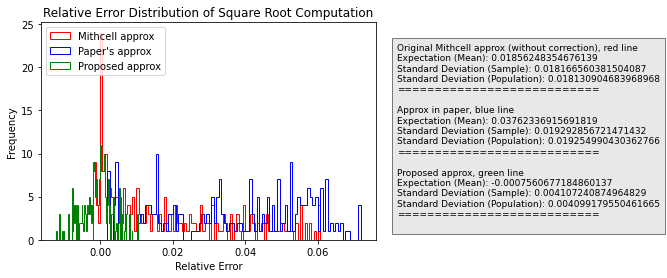

In [17]:
# Plot error distribution for root
plt.hist(error_root_mitchell, bins=100, edgecolor='red', histtype='step', label='Mithcell approx')
plt.hist(error_root_paper, bins=100, edgecolor='blue', histtype='step',label="Paper's approx")
plt.hist(error_root_proposed, bins=100, edgecolor='green', histtype='step', label='Proposed approx')

plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title('Relative Error Distribution of Square Root Computation')

stats_lines = []

stats_lines.append("Original Mithcell approx (without correction), red line")
mean_value = np.mean(error_root_mitchell)
std_dev_sample = np.std(error_root_mitchell, ddof=1)
std_dev_population = np.std(error_root_mitchell, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_lines.append("Approx in paper, blue line")
mean_value = np.mean(error_root_paper)
std_dev_sample = np.std(error_root_paper, ddof=1)
std_dev_population = np.std(error_root_paper, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_lines.append("Proposed approx, green line")
mean_value = np.mean(error_root_proposed)
std_dev_sample = np.std(error_root_proposed, ddof=1)
std_dev_population = np.std(error_root_proposed, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")

stats_lines.append("===========================\n")
plt.legend(loc="upper left")
stats_text = "\n".join(stats_lines)
plt.figtext(0.95, 0.17, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})
plt.savefig("ErrorTermCompare/Compare_root_error.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# Quick convert: FP -> Fixed point
Used to copy to the LUT HDL code

In [21]:
import numpy as np

def float_to_fixedpoint(f, bits_fractional):
    """Converts a floating point number to fixed point format with specified fractional bits."""
    fixed_point_value = int(f * (2 ** bits_fractional))
    return fixed_point_value

def generate_LUT(input_file, output_file, bits_fractional, num_segment):
    cnt = 0
    segment_width = int(np.log2(num_segment))
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            line = line.strip()
            if line:
                try:
                    num = float(line)
                    if num < 1:
                        fixed_point = float_to_fixedpoint(num, bits_fractional)
                        binary_representation = format(fixed_point, f'0{bits_fractional}b')
                        cnt_representation = format(cnt, f'0{segment_width}b')
                        outfile.write(f'when "{cnt_representation}" => correction_term <= "{binary_representation}";\n')
                        cnt = cnt+1
                        if cnt == num_segment:
                          cnt = 0
                          zero_representation = format(0, f'0{bits_fractional}b')
                          outfile.write(f'when others => correction_term <= "{zero_representation}";\n\n')
                    else:
                        print(f"Warning: Value {num} exceeds range (>= 1). Check again.")
                except ValueError:
                    print(f"Warning: Invalid number '{line}' in the input file. Skipping.")

In [26]:
bits_fractional = 15
NUM_SEGMENT = 3
input_file = f'CorrectionTableLog/log_{NUM_SEGMENT}s_{bits_fractional+1}b.txt'
output_file = f'CorrectionTableLog/output_{NUM_SEGMENT}s_{bits_fractional+1}b.txt'

root_correction_pd = generate_root_pd_new(NUM_SEGMENT)

with open(input_file, 'w') as f:
    for value in root_correction_pd.values.flatten():
        f.write(f"{value}\n")
        
num_segment = 2**NUM_SEGMENT
generate_LUT(input_file, output_file, bits_fractional, num_segment)

# Only test for root

In [148]:
NUM_SEGMENT = 4
WIDTH = 32

## Software test

### Generate table

In [149]:
current_tab = generate_root_pd_new(NUM_SEGMENT)

In [150]:
current_tab

,0.0 → 0.0625,0.0625 → 0.125,0.125 → 0.1875,0.1875 → 0.25,0.25 → 0.3125,0.3125 → 0.375,0.375 → 0.4375,0.4375 → 0.5,0.5 → 0.5625,0.5625 → 0.625,0.625 → 0.6875,0.6875 → 0.75,0.75 → 0.8125,0.8125 → 0.875,0.875 → 0.9375,0.9375 → 1.0
k <= 1,0.000000,0.000000,0.085786,0.017949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
k > 1 even,0.000224,0.001494,0.003846,0.007113,0.011162,0.015883,0.021187,0.027000,0.033260,0.039915,0.046921,0.054240,0.061840,0.069694,0.077777,0.08607
k > 1 odd,0.082250,0.067845,0.055621,0.045236,0.036420,0.028951,0.022649,0.017364,0.012972,0.009366,0.006459,0.004173,0.002443,0.001213,0.000433,0.00006


### Plot result: Full

In [ ]:
# All case (for small WIDTH)
abs_errors_full = []
relative_errors_full = []

inputs = [x for x in range (1, 2**WIDTH)]

for in1 in inputs:
  abs_error, relative_error = get_error_root_new(in1, WIDTH, NUM_SEGMENT, current_tab)
  abs_errors_full.append(abs_error)
  relative_errors_full.append(relative_error)

relative_errors_full.insert(0,0)
abs_errors_full.insert(0,0)
inputs.insert(0,0)

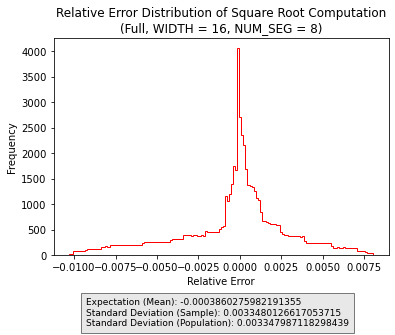

In [65]:
# Plot error distribution of relative error
plt.hist(relative_errors_full, bins=150, edgecolor='red', histtype='step')
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title(f'Relative Error Distribution of Square Root Computation\n(Full, WIDTH = {WIDTH}, NUM_SEG = {2**NUM_SEGMENT})')

mean_value = np.mean(relative_errors_full)
std_dev_sample = np.std(relative_errors_full, ddof=1)
std_dev_population = np.std(relative_errors_full, ddof=0)
stats_lines = []
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")

stats_text = "\n".join(stats_lines)
plt.figtext(0.2, -0.12, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})
plt.savefig(f"SWRootFig/Relative_histogram_f_{WIDTH}b_{2**NUM_SEGMENT}s.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

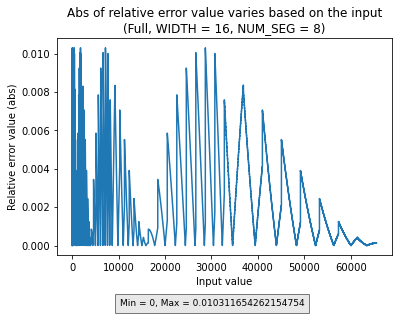

In [66]:
relative_errors_full_abs = [abs(x) for x in relative_errors_full]
plt.plot(range(len(relative_errors_full_abs)), relative_errors_full_abs)

plt.xlabel('Input value')
plt.ylabel('Relative error value (abs)')
plt.title(f'Abs of relative error value varies based on the input\n(Full, WIDTH = {WIDTH}, NUM_SEG = {2**NUM_SEGMENT})')

stats_text = f"Min = {min(relative_errors_full_abs)}, Max = {max(relative_errors_full_abs)}"
plt.figtext(0.27, -0.05, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.savefig(f"SWRootFig/AbsRelative_vs_input_f_{WIDTH}b_{2**NUM_SEGMENT}s.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

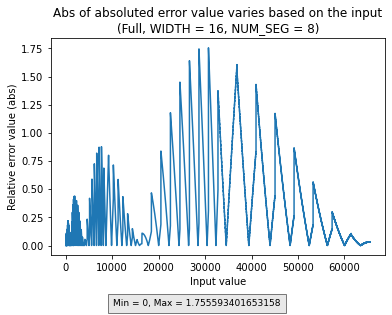

In [67]:
abs_errors_full_abs = [abs(x) for x in abs_errors_full]
plt.plot(range(len(abs_errors_full_abs)), abs_errors_full_abs)

plt.xlabel('Input value')
plt.ylabel('Relative error value (abs)')
plt.title(f'Abs of absoluted error value varies based on the input\n(Full, WIDTH = {WIDTH}, NUM_SEG = {2**NUM_SEGMENT})')

stats_text = f"Min = {min(abs_errors_full_abs)}, Max = {max(abs_errors_full_abs)}"
plt.figtext(0.27, -0.05, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.savefig(f"SWRootFig/AbsAbsoluted_vs_input_f_{WIDTH}b_{2**NUM_SEGMENT}s.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

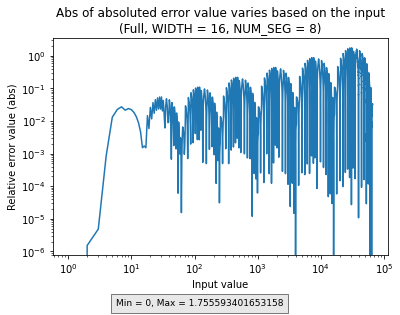

In [68]:
abs_errors_full_abs = [abs(x) for x in abs_errors_full]
plt.plot(range(len(abs_errors_full_abs)), abs_errors_full_abs)

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Input value')
plt.ylabel('Relative error value (abs)')
plt.title(f'Abs of absoluted error value varies based on the input\n(Full, WIDTH = {WIDTH}, NUM_SEG = {2**NUM_SEGMENT})')

stats_text = f"Min = {min(abs_errors_full_abs)}, Max = {max(abs_errors_full_abs)}"
plt.figtext(0.27, -0.05, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.savefig(f"SWRootFig/AbsAbsoluted_vs_input_logscale_f_{WIDTH}b_{2**NUM_SEGMENT}s.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

### Plot result: Only square

In [ ]:
# Only square case (for large WIDTH)
abs_errors_square = []
relative_errors_square = []
inputs_square = [x*x for x in range (1, 2**(WIDTH//2))]

for in1 in inputs_square:
  abs_error, relative_error = get_error_root_new(in1, WIDTH, NUM_SEGMENT, current_tab)
  abs_errors_square.append(abs_error)
  relative_errors_square.append(relative_error)

# Add for input = 0
relative_errors_square.insert(0,0)
abs_errors_square.insert(0,0)
inputs_square.insert(0,0)

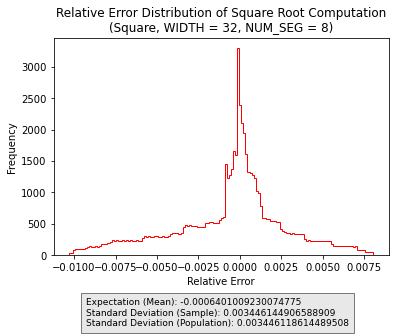

In [80]:
# Plot error distribution of relative error
plt.hist(relative_errors_square, bins=150, edgecolor='red', histtype='step')
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title(f'Relative Error Distribution of Square Root Computation\n(Square, WIDTH = {WIDTH}, NUM_SEG = {2**NUM_SEGMENT})')

mean_value = np.mean(relative_errors_square)
std_dev_sample = np.std(relative_errors_square, ddof=1)
std_dev_population = np.std(relative_errors_square, ddof=0)
stats_lines = []
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")

stats_text = "\n".join(stats_lines)
plt.figtext(0.2, -0.12, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})
plt.savefig(f"SWRootFig/Relative_histogram_s_{WIDTH}b_{2**NUM_SEGMENT}s.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

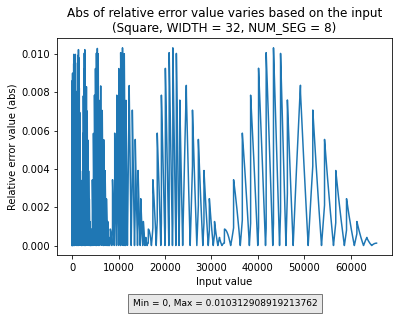

In [81]:
relative_errors_square_abs = [abs(x) for x in relative_errors_square]
plt.plot(range(len(relative_errors_square_abs)), relative_errors_square_abs)

plt.xlabel('Input value')
plt.ylabel('Relative error value (abs)')
plt.title(f'Abs of relative error value varies based on the input\n(Square, WIDTH = {WIDTH}, NUM_SEG = {2**NUM_SEGMENT})')

stats_text = f"Min = {min(relative_errors_square_abs)}, Max = {max(relative_errors_square_abs)}"
plt.figtext(0.3, -0.05, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.savefig(f"SWRootFig/AbsRelative_vs_input_s_{WIDTH}b_{2**NUM_SEGMENT}s.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

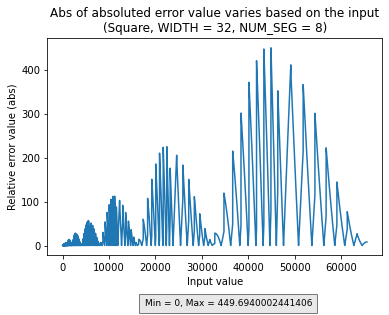

In [ ]:
abs_errors_square_abs = [abs(x) for x in abs_errors_square]
plt.plot(range(len(abs_errors_square_abs)), abs_errors_square_abs)

plt.xlabel('Input value')
plt.ylabel('Relative error value (abs)')
plt.title(f'Abs of absoluted error value varies based on the input\n(Square, WIDTH = {WIDTH}, NUM_SEG = {2**NUM_SEGMENT})')

stats_text = f"Min = {min(abs_errors_square_abs)}, Max = {max(abs_errors_square_abs)}"
plt.figtext(0.35, -0.05, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.savefig(f"SWRootFig/AbsAbsoluted_vs_input_s_{WIDTH}b_{2**NUM_SEGMENT}s.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [83]:
abs_errors_square_abs

[0,
 0.0,
 0.0008591767400503159,
 0.024143421091139317,
 0.0017183534801006317,
 0.02135111577808857,
 0.04828684218227863,
 0.01782357133924961,
 0.0034367069602012634,
 0.04567888006567955,
 0.04270223155617714,
 0.09288864582777023,
 0.09657368436455727,
 0.01976882293820381,
 0.03564714267849922,
 0.016626913100481033,
 0.006873413920402527,
 0.05642062425613403,
 0.0913577601313591,
 0.10424962639808655,
 0.08540446311235428,
 0.02803846448659897,
 0.18577729165554047,
 0.06486265361309052,
 0.19314736872911453,
 0.04122763127088547,
 0.03953764587640762,
 0.07052109390497208,
 0.07129428535699844,
 0.055570296943187714,
 0.03325382620096207,
 0.011682577431201935,
 0.013746827840805054,
 0.011868655681610107,
 0.11284124851226807,
 0.034716248512268066,
 0.1827155202627182,
 0.0420905202627182,
 0.2084992527961731,
 0.005374252796173096,
 0.17080892622470856,
 0.35295192897319794,
 0.05607692897319794,
 0.21392372250556946,
 0.37155458331108093,
 0.019070416688919067,
 0.1297253

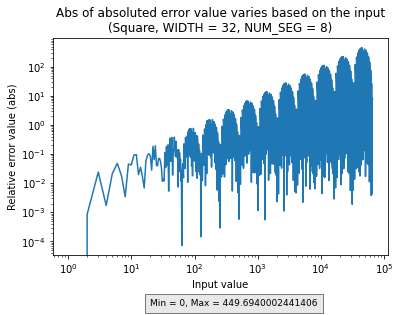

In [ ]:
abs_errors_square_abs = [abs(x) for x in abs_errors_square]
plt.plot(range(len(abs_errors_square_abs)), abs_errors_square_abs)

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Input value')
plt.ylabel('Relative error value (abs)')
plt.title(f'Abs of absoluted error value varies based on the input\n(Square, WIDTH = {WIDTH}, NUM_SEG = {2**NUM_SEGMENT})')

stats_text = f"Min = {min(abs_errors_square_abs)}, Max = {max(abs_errors_square_abs)}"
plt.figtext(0.35, -0.05, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.savefig(f"SWRootFig/AbsAbsoluted_vs_input_logscale_s_{WIDTH}b_{2**NUM_SEGMENT}s.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

## Verify HW result and compare with SW

## Fixed point, full (for 8, 16 bit)

In [51]:
if (WIDTH < 17):
  with open(f'HWSW_Compare/output_results_{NUM_SEGMENT}seg_{WIDTH}bit_fix.txt', 'r') as file:
      results = [int(line.strip())/(2**(WIDTH - 1)) for line in file.readlines()]
  golden_res = [sqrt(x) for x in range(2**WIDTH)]

  relative_errors_hw = [(results[i] - golden_res[i]) / golden_res[i] for i in range(1, 2**WIDTH)]
  abs_errors_hw = [(results[i] - golden_res[i]) for i in range(1, 2**WIDTH)]

  if (golden_res[0] - results[0] == 0):
    relative_errors_hw.insert(0, 0) #For case golden_res = 0
    abs_errors_hw.insert(0, 0)

In [52]:
# All case (for small WIDTH)
abs_errors_full = []
relative_errors_full = []

inputs = [x for x in range (1, 2**WIDTH)]

for in1 in inputs:
  abs_error, relative_error = get_error_root_new(in1, WIDTH, NUM_SEGMENT, current_tab)
  abs_errors_full.append(abs_error)
  relative_errors_full.append(relative_error)

relative_errors_full.insert(0,0)
abs_errors_full.insert(0,0)
inputs.insert(0,0)

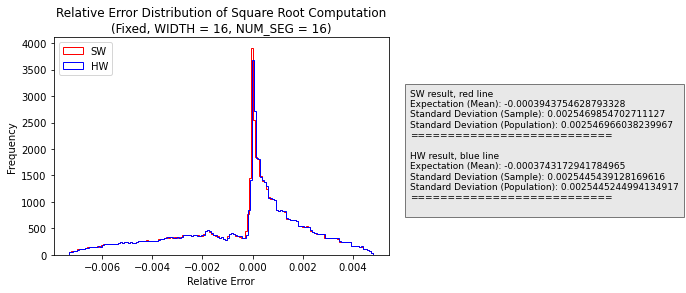

In [53]:
#Plot error distribution
plt.hist(relative_errors_full, bins=150, edgecolor='red', histtype='step', label="SW")
plt.hist(relative_errors_hw, bins=150, edgecolor='blue', histtype='step', label="HW")
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title(f'Relative Error Distribution of Square Root Computation\n(Fixed, WIDTH = {WIDTH}, NUM_SEG = {2**NUM_SEGMENT})')

stats_lines = []
stats_lines.append("SW result, red line")
mean_value = np.mean(relative_errors_full)
std_dev_sample = np.std(relative_errors_full, ddof=1)
std_dev_population = np.std(relative_errors_full, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_lines.append("HW result, blue line")
mean_value = np.mean(relative_errors_hw)
std_dev_sample = np.std(relative_errors_hw, ddof=1)
std_dev_population = np.std(relative_errors_hw, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

plt.legend(loc="upper left")
stats_text = "\n".join(stats_lines)
plt.figtext(0.95, 0.28, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})
plt.savefig(f"HWSW_Compare/Compare_HWSW_hist_relative_f_{WIDTH}b_{2**NUM_SEGMENT}s.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

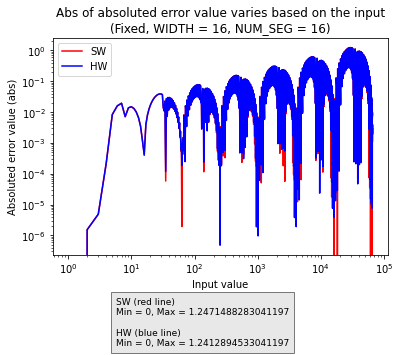

In [54]:
# Plot absoluted error vs input
abs_errors_hw_abs = [abs(x) for x in abs_errors_hw]
abs_errors_full_abs = [abs(x) for x in abs_errors_full]
plt.plot(range(len(abs_errors_full_abs)), abs_errors_full_abs, 'r-', label="SW" )
plt.plot(range(len(abs_errors_hw_abs)), abs_errors_hw_abs, 'b-', label="HW" )

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Input value')
plt.ylabel('Absoluted error value (abs)')
plt.title(f'Abs of absoluted error value varies based on the input\n(Fixed, WIDTH = {WIDTH}, NUM_SEG = {2**NUM_SEGMENT})')

stats_text = f"SW (red line)\nMin = {min(abs_errors_full_abs)}, Max = {max(abs_errors_full_abs)}\n"
stats_text += f"\nHW (blue line)\nMin = {min(abs_errors_hw_abs)}, Max = {max(abs_errors_hw_abs)}"
plt.figtext(0.27, -0.19, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.legend(loc = "upper left")
plt.savefig(f"HWSW_Compare/Compare_HWSW_absErrorvsInput_f_{WIDTH}b_{2**NUM_SEGMENT}s.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

## Int output

In [151]:
abs_errors_int_sw = []
relative_errors_int_sw = []

if (WIDTH > 16):
  inputs_int = [x*x for x in range (1, 2**(WIDTH//2))]
else:
  inputs_int = [x for x in range (1, 2**(WIDTH))]

for in1 in inputs_int:
  error_abs, error_relative = get_error_root_int_new(in1, WIDTH, NUM_SEGMENT, current_tab)
  abs_errors_int_sw.append(error_abs)
  relative_errors_int_sw.append(error_relative)

inputs_int.insert(0,0)
abs_errors_int_sw.insert(0,0)
relative_errors_int_sw.insert(0,0)

In [152]:
if (WIDTH < 17):
  with open(f'HWSW_Compare/output_results_{NUM_SEGMENT}seg_{WIDTH}bit_all.txt', 'r') as file:
      results = [int(line.strip()) for line in file.readlines()]
  golden_res = [int(sqrt(x)) for x in range(2**WIDTH)]

  relative_errors_int_hw = [(results[i] - golden_res[i]) / golden_res[i] for i in range(1, 2**WIDTH)]
  abs_errors_int_hw = [(results[i] - golden_res[i]) for i in range(1, 2**WIDTH)]

  if (golden_res[0] - results[0] == 0):
    relative_errors_int_hw.insert(0, 0) #For case golden_res = 0
    abs_errors_int_hw.insert(0, 0)
else:
  with open(f'HWSW_Compare/output_results_{NUM_SEGMENT}seg_{WIDTH}bit.txt', 'r') as file:
      results = [int(line.strip()) for line in file.readlines()]
  golden_res = [x for x in range(2**(WIDTH//2))]

  relative_errors_int_hw = [(results[i] - golden_res[i]) / golden_res[i] for i in range(1, len(results))]
  abs_errors_int_hw = [(results[i] - golden_res[i]) for i in range(1, len(results))]

  if (golden_res[0] - results[0] == 0):
    relative_errors_int_hw.insert(0, 0) #For case golden_res = 0
    abs_errors_int_hw.insert(0, 0)

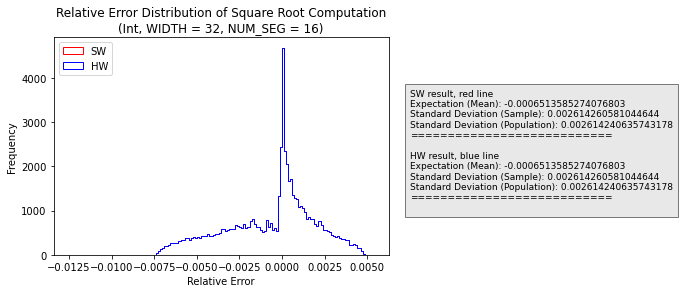

In [153]:
#Plot error distribution
plt.hist(relative_errors_int_sw, bins=150, edgecolor='red', histtype='step', label="SW")
plt.hist(relative_errors_int_hw, bins=150, edgecolor='blue', histtype='step', label="HW")
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title(f'Relative Error Distribution of Square Root Computation\n(Int, WIDTH = {WIDTH}, NUM_SEG = {2**NUM_SEGMENT})')

stats_lines = []
stats_lines.append("SW result, red line")
mean_value = np.mean(relative_errors_int_sw)
std_dev_sample = np.std(relative_errors_int_sw, ddof=1)
std_dev_population = np.std(relative_errors_int_sw, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_lines.append("HW result, blue line")
mean_value = np.mean(relative_errors_int_hw)
std_dev_sample = np.std(relative_errors_int_hw, ddof=1)
std_dev_population = np.std(relative_errors_int_hw, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

plt.legend(loc="upper left")
stats_text = "\n".join(stats_lines)
plt.figtext(0.95, 0.28, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})
plt.savefig(f"HWSW_Compare/Compare_HWSW_hist_relative_int_{WIDTH}b_{2**NUM_SEGMENT}s.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

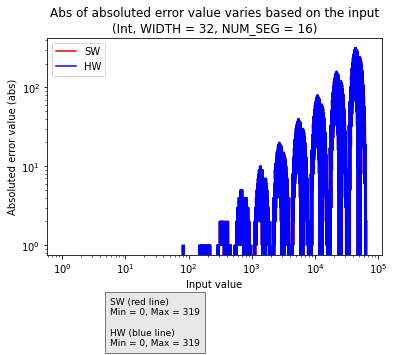

In [154]:
# Plot absoluted error vs input
abs_errors_int_hw_abs = [abs(x) for x in abs_errors_int_hw]
abs_errors_int_sw_abs = [abs(x) for x in abs_errors_int_sw]
plt.plot(range(len(abs_errors_int_sw_abs)), abs_errors_int_sw_abs, 'r-', label="SW" )
plt.plot(range(len(abs_errors_int_hw_abs)), abs_errors_int_hw_abs, 'b-', label="HW" )

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Input value')
plt.ylabel('Absoluted error value (abs)')
plt.title(f'Abs of absoluted error value varies based on the input\n(Int, WIDTH = {WIDTH}, NUM_SEG = {2**NUM_SEGMENT})')

stats_text = f"SW (red line)\nMin = {min(abs_errors_int_sw_abs)}, Max = {max(abs_errors_int_sw_abs)}\n"
stats_text += f"\nHW (blue line)\nMin = {min(abs_errors_int_hw_abs)}, Max = {max(abs_errors_int_hw_abs)}"
plt.figtext(0.27, -0.19, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.legend(loc = "upper left")
plt.savefig(f"HWSW_Compare/Compare_HWSW_absErrorvsInput_int_{WIDTH}b_{2**NUM_SEGMENT}s.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [155]:
WIDTH = 32

In [157]:
with open(f'HWSW_Compare/output_results_old_32bit.txt', 'r') as file:
    results = [int(line.strip()) for line in file.readlines()]
golden_res = [x for x in range(2**(WIDTH//2))]

relative_errors_oldarc = [(results[i] - golden_res[i]) / golden_res[i] for i in range(1, len(results))]
abs_errors_oldarc = [(results[i] - golden_res[i]) for i in range(1, len(results))]

if (golden_res[0] - results[0] == 0):
    relative_errors_oldarc.insert(0, 0) #For case golden_res = 0
    abs_errors_oldarc.insert(0, 0)

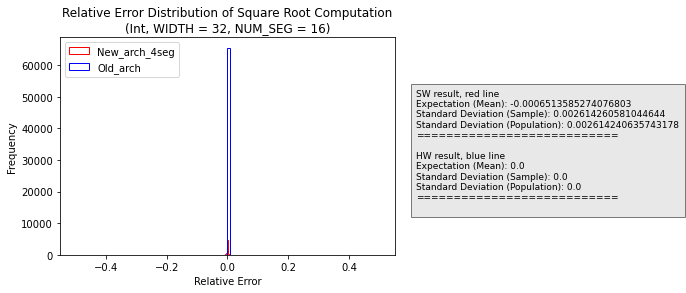

In [158]:
#Plot error distribution
plt.hist(relative_errors_int_hw, bins=150, edgecolor='red', histtype='step', label="New_arch_4seg")
plt.hist(relative_errors_oldarc, bins=150, edgecolor='blue', histtype='step', label="Old_arch")
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title(f'Relative Error Distribution of Square Root Computation\n(Int, WIDTH = {WIDTH}, NUM_SEG = {2**NUM_SEGMENT})')

stats_lines = []
stats_lines.append("SW result, red line")
mean_value = np.mean(relative_errors_int_hw)
std_dev_sample = np.std(relative_errors_int_hw, ddof=1)
std_dev_population = np.std(relative_errors_int_hw, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

stats_lines.append("HW result, blue line")
mean_value = np.mean(relative_errors_oldarc)
std_dev_sample = np.std(relative_errors_oldarc, ddof=1)
std_dev_population = np.std(relative_errors_oldarc, ddof=0)
stats_lines.append(f"Expectation (Mean): {mean_value}")
stats_lines.append(f"Standard Deviation (Sample): {std_dev_sample}")
stats_lines.append(f"Standard Deviation (Population): {std_dev_population}")
stats_lines.append("===========================\n")

plt.legend(loc="upper left")
stats_text = "\n".join(stats_lines)
plt.figtext(0.95, 0.28, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})
plt.savefig(f"HWSW_Compare/Compare_NewvsOldArch_32b.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

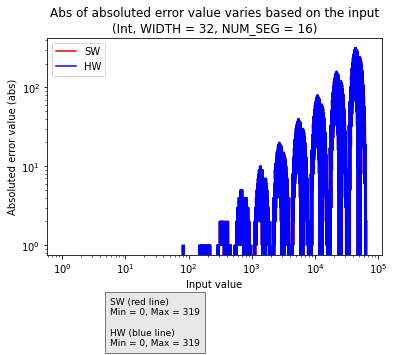

In [159]:
# Plot absoluted error vs input
abs_errors_int_hw_abs = [abs(x) for x in abs_errors_int_hw]
abs_errors_int_sw_abs = [abs(x) for x in abs_errors_int_sw]
plt.plot(range(len(abs_errors_int_sw_abs)), abs_errors_int_sw_abs, 'r-', label="SW" )
plt.plot(range(len(abs_errors_int_hw_abs)), abs_errors_int_hw_abs, 'b-', label="HW" )

plt.xscale("log")
plt.yscale("log")
plt.xlabel('Input value')
plt.ylabel('Absoluted error value (abs)')
plt.title(f'Abs of absoluted error value varies based on the input\n(Int, WIDTH = {WIDTH}, NUM_SEG = {2**NUM_SEGMENT})')

stats_text = f"SW (red line)\nMin = {min(abs_errors_int_sw_abs)}, Max = {max(abs_errors_int_sw_abs)}\n"
stats_text += f"\nHW (blue line)\nMin = {min(abs_errors_int_hw_abs)}, Max = {max(abs_errors_int_hw_abs)}"
plt.figtext(0.27, -0.19, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.legend(loc = "upper left")
plt.savefig(f"HWSW_Compare/Compare_HWSW_absErrorvsInput_int_{WIDTH}b_{2**NUM_SEGMENT}s.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# New approx method

In [3]:
SEG_NUM = 1

## Util function

In [94]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_apprx(error):
  rms_error = np.sqrt(np.mean(error**2))
  mean_error = np.mean(error)
  std_error = np.std(error)
  return [rms_error, mean_error, std_error]

# Try multiple apprx
def find_approx(power_list, x, y_ideal):
  approximations = []
  for A in power_list:
      for B in power_list:
          y_approx = A * x + B
          error = y_approx - y_ideal
          rms, mean, std = evaluate_apprx(error)

          # Store the results along with the parameters A and B
          approximations.append({'A': A, 'B': B, 'rms': rms, 'mean': mean, 'std': std, 'approx_func': f'y = {A}*x + {B}'})
  # Sort Approximation with lowest RMS
  best_approx = sorted(approximations, key=lambda x: x['rms'])[0]
  # Print results
  print(f"{best_approx['approx_func']} (RMS: {best_approx['rms']:.6f})")
  return best_approx

def find_all_approx(SEG_NUM):
  print(f"Using {SEG_NUM} segments to approx log2(x+1)")

  inter = [x/SEG_NUM for x in range(1,SEG_NUM+1)]
  inter.insert(0,0.0001)

  approximations = []
  x_all = np.array([])
  ideal_y = np.array([])
  approx_y = np.array([])
  for i in range(SEG_NUM):
    print(f"\nSegment {i+1}: [{inter[i]}, {inter[i+1]})")
    x = np.linspace(inter[i], inter[i+1], 10000)
    y_log2 = np.log2(x + 1)

    current_approx = find_approx(power_list, x, y_log2)
    A = current_approx['A']
    B = current_approx['B']
    y_approx = A * x + B

    approximations.append(current_approx)
    x_all = np.concatenate((x_all, x))
    ideal_y = np.concatenate((ideal_y, y_log2))
    approx_y = np.concatenate((approx_y, y_approx))
    i=i+1

  error = approx_y - ideal_y
  return [approximations, x_all, ideal_y, approx_y, error]

## Plot result

In [138]:
MIN_POWER = -8
MAX_POWER = 8
power_list = [2**i for i in range(MIN_POWER, MAX_POWER)]
power_list.append(0)

approximations, x_all, ideal_y, approx_y, error = find_all_approx(SEG_NUM)

Using 1 segments to approx log2(x+1)

Segment 1: [0.0001, 1.0)
y = 1*x + 0.0625 (RMS: 0.026206)


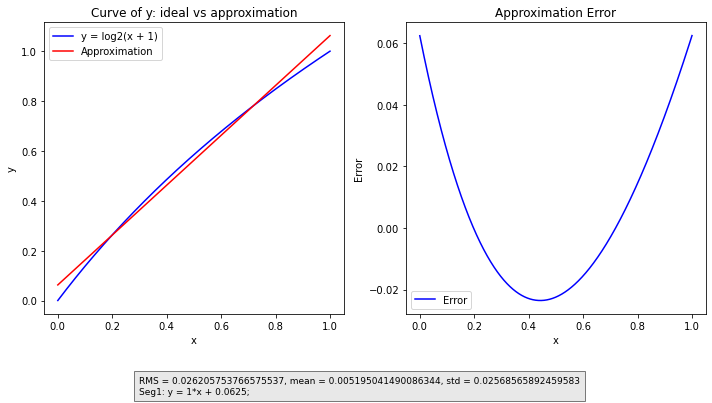

In [140]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(x_all, ideal_y, label='y = log2(x + 1)', color='blue')
plt.plot(x_all, approx_y, label='Approximation', color='red')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Curve of y: ideal vs approximation')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(x_all, error, label='Error', color='blue')
plt.xlabel('x')
plt.ylabel('Error')
plt.title('Approximation Error')
plt.legend()

plt.tight_layout()

rms_error, mean_error, std_error = evaluate_apprx(error)
stats_text = f"RMS = {rms_error}, mean = {mean_error}, std = {std_error}\n"
for i in range(SEG_NUM):
    stats_text += f"Seg{i+1}: {approximations[0]['approx_func']};     "
    if (i%4==3) and i != (SEG_NUM - 1):
        stats_text += "\n"

plt.figtext(0.2 - SEG_NUM/500, -0.1 - SEG_NUM/160, stats_text, ha="left", fontsize=9, bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.savefig(f"New_approx_fig/Approximate log2(x+1) with {SEG_NUM} segments.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()